In [ ]:
#linking drive to session then uploading data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_metadata_gc.zip'

Archive:  /content/drive/MyDrive/HAM10000_metadata_gc.zip
  inflating: HAM10000_metadata       


In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_images_part_1_gc'

In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_images_part_2_gc'

In [ ]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import seaborn as sns
from PIL import Image
import tensorflow as tf
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import keras
from keras.utils.np_utils import to_categorical 
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, GlobalAveragePooling2D, ZeroPadding2D
from keras.applications import vgg16
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.models import Model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  


In [ ]:
#datasets and evaluating datasets

In [ ]:
md = pd.read_csv("/content/HAM10000_metadata")
md

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [ ]:
#resize images
im_size = 224

In [ ]:
#numerical labling of diagnosis categories
lab_enc = LabelEncoder()
lab_enc.fit(md['dx'])
LabelEncoder()
print(list(lab_enc.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
md['label'] = lab_enc.transform(md["dx"]) 

In [ ]:
#adding image paths for each image in dataset

In [ ]:
fldr1 = '/content/HAM10000_images_part_1'
fldr2 = '/content/HAM10000_images_part_2'

im_paths = []

for i in md['image_id']:
  fid = i

  fn = '/' + fid + '.jpg'

  if os.path.isfile(fldr1 + fn) == True:
    im_paths.append(fldr1+fn)
  else:
    im_paths.append(fldr2+fn)

In [ ]:
md['image_paths'] = im_paths
md

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label,image_paths
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2,/content/HAM10000_images_part_2/ISIC_0031633.jpg
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033084.jpg
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033550.jpg
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033536.jpg
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0032854.jpg


In [ ]:
#flattening image to ndarray

In [ ]:
md['image'] = md['image_paths'].map(lambda x: np.asarray(Image.open(x).resize((im_size,im_size))))
md

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label,image_paths,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0027419.jpg,"[[[187, 150, 192], [190, 154, 195], [192, 156,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025030.jpg,"[[[24, 13, 22], [25, 13, 23], [24, 14, 23], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0026769.jpg,"[[[186, 127, 135], [188, 129, 137], [191, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025661.jpg,"[[[23, 11, 15], [24, 11, 18], [24, 10, 19], [2..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2,/content/HAM10000_images_part_2/ISIC_0031633.jpg,"[[[125, 83, 105], [132, 89, 112], [138, 93, 11..."
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033084.jpg,"[[[115, 92, 101], [108, 92, 96], [108, 91, 98]..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033550.jpg,"[[[4, 6, 3], [5, 6, 3], [6, 6, 5], [7, 8, 4], ..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033536.jpg,"[[[105, 92, 96], [109, 102, 103], [118, 109, 1..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0032854.jpg,"[[[156, 115, 138], [158, 117, 138], [160, 121,..."


In [ ]:
#split data into training and testing set, then standardize ndarrays of images by pixel values, target array of disease categories

In [ ]:
train, test = train_test_split(md, test_size=0.25, random_state=29, shuffle=True)

In [ ]:
trainX = np.array(train["image"].tolist())
trainX = trainX/225

trainY = train['label']
trainY_dx = to_categorical(trainY, num_classes=7)

In [ ]:
testX = np.array(test["image"].tolist())
testX = testX/225

testY = test['label']
testY_dx = to_categorical(testY, num_classes=7)

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#finetuning of the pretrained model. 13 conv layers frozen, 5 max pooling layers frozen, top dense layers replaced to make model architecture compatible with number of disease categories. Addiotnally global pooling layer added after frozen layers

In [ ]:
img_rows, img_cols = 224, 224 

vgg_mod = vgg16.VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in vgg_mod.layers:
    layer.trainable = False

In [ ]:
for (i,layer) in enumerate(vgg_mod.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [ ]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model 

In [ ]:
num_classes = 7

FC_Head = lw(vgg_mod, num_classes)
model = Model(inputs = vgg_mod.input, outputs = FC_Head)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
#specific hyperparameters then fitting of the models
batch_size = 64
epochs = 75

In [ ]:
mod_fit = model.fit(
    trainX, trainY_dx,
    epochs=epochs,
    batch_size = batch_size,
    verbose=2)

Epoch 1/75
118/118 - 17s - loss: 1.0134 - accuracy: 0.6711 - 17s/epoch - 141ms/step
Epoch 2/75
118/118 - 6s - loss: 0.8974 - accuracy: 0.6886 - 6s/epoch - 51ms/step
Epoch 3/75
118/118 - 6s - loss: 0.8500 - accuracy: 0.6932 - 6s/epoch - 51ms/step
Epoch 4/75
118/118 - 6s - loss: 0.8307 - accuracy: 0.7014 - 6s/epoch - 51ms/step
Epoch 5/75
118/118 - 6s - loss: 0.8032 - accuracy: 0.7096 - 6s/epoch - 50ms/step
Epoch 6/75
118/118 - 6s - loss: 0.7774 - accuracy: 0.7168 - 6s/epoch - 51ms/step
Epoch 7/75
118/118 - 6s - loss: 0.7596 - accuracy: 0.7239 - 6s/epoch - 51ms/step
Epoch 8/75
118/118 - 6s - loss: 0.7349 - accuracy: 0.7352 - 6s/epoch - 51ms/step
Epoch 9/75
118/118 - 6s - loss: 0.7297 - accuracy: 0.7327 - 6s/epoch - 50ms/step
Epoch 10/75
118/118 - 6s - loss: 0.7089 - accuracy: 0.7416 - 6s/epoch - 51ms/step
Epoch 11/75
118/118 - 6s - loss: 0.6856 - accuracy: 0.7502 - 6s/epoch - 51ms/step
Epoch 12/75
118/118 - 6s - loss: 0.6885 - accuracy: 0.7486 - 6s/epoch - 51ms/step
Epoch 13/75
118/118 - 

In [ ]:
#overall testing accuracy
mod_acc_val = model.evaluate(testX, testY_dx)
print('Test accuracy:', mod_acc_val[1])

79/79 [==============================] - 3s 28ms/step - loss: 1.6716 - accuracy: 0.7185
Test accuracy: 0.7184504866600037


In [ ]:
#predictions from the models 

In [ ]:
y_pred = model.predict(testX)

79/79 [==============================] - 2s 24ms/step


In [ ]:
y_pred_classes = np.argmax(y_pred, axis = 1) 

In [ ]:
y_true = np.argmax(testY_dx, axis = 1) 

In [ ]:
#class wise precision and recall metrics and overall accuracy, as well as class wise accuracies calculated from (TP+TN)/(TP+TN+FP+FN)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred_classes, target_names = ['Akiec', 'Bcc', 'Bkl', 'Df', 'Mel', 'Nv', 'Vasc'])
print(report)

              precision    recall  f1-score   support

       Akiec       0.46      0.23      0.31        91
         Bcc       0.75      0.34      0.47       132
         Bkl       0.37      0.55      0.44       271
          Df       0.23      0.30      0.26        30
         Mel       0.44      0.43      0.43       277
          Nv       0.86      0.86      0.86      1669
        Vasc       0.72      0.38      0.50        34

    accuracy                           0.72      2504
   macro avg       0.55      0.44      0.47      2504
weighted avg       0.73      0.72      0.72      2504



In [ ]:
model_accuracy = metrics.accuracy_score(y_true, y_pred_classes)
print(model_accuracy)

0.7184504792332268


In [ ]:
def classwise_accuracy():
   a = pd.crosstab(y_true,y_pred_classes)
   print(a.max(axis=1)/a.sum(axis=1))
classwise_accuracy()

row_0
0    0.329670
1    0.340909
2    0.549815
3    0.300000
4    0.429603
5    0.864590
6    0.441176
dtype: float64


In [ ]:
#confusion matrix and percent misclassified

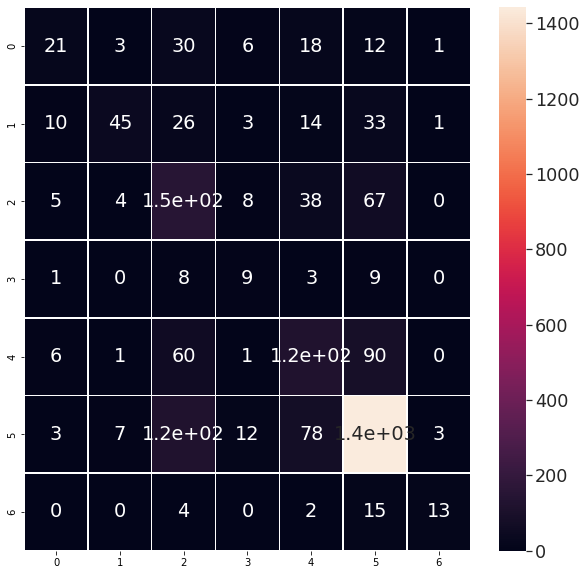

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [ ]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)

incorr_fraction = incorr_fraction.tolist()

incorr_fraction = [round(item, 2) for item in incorr_fraction]

incorr_fraction

[0.77, 0.66, 0.45, 0.7, 0.57, 0.14, 0.62]

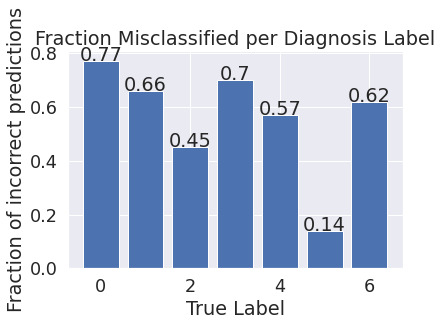

In [ ]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
  
if __name__ == '__main__':
  plt.bar(np.arange(7), incorr_fraction)
  addlabels(np.arange(7), incorr_fraction)
  plt.title("Fraction Misclassified per Diagnosis Label")
  plt.xlabel('True Label')
  plt.ylabel('Fraction of incorrect predictions')